In [ ]:
!nvidia-smi

Thu Jun 29 14:11:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    35W /  70W |   7299MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## Install Segment Anything Model (SAM) and other dependencies

In [ ]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-c1e6_1ng
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-c1e6_1ng
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

### Download SAM weights

In [ ]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
mkdir: cannot create directory ‘/content/weights’: File exists
/content/weights


In [ ]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


## Download Example Data

**NONE:** Let's download few example images. Feel free to use your images or videos.

In [ ]:
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg

/content
mkdir: cannot create directory ‘/content/data’: File exists
/content/data


## Load Model

In [ ]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

## Automated Mask Generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [ ]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
import os

IMAGE_NAME = "dog.jpeg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

### Generate masks with SAM

In [ ]:
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

### Output format

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

In [ ]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


### Results visualisation with Supervision

As of version `0.5.0` Supervision has native support for SAM.

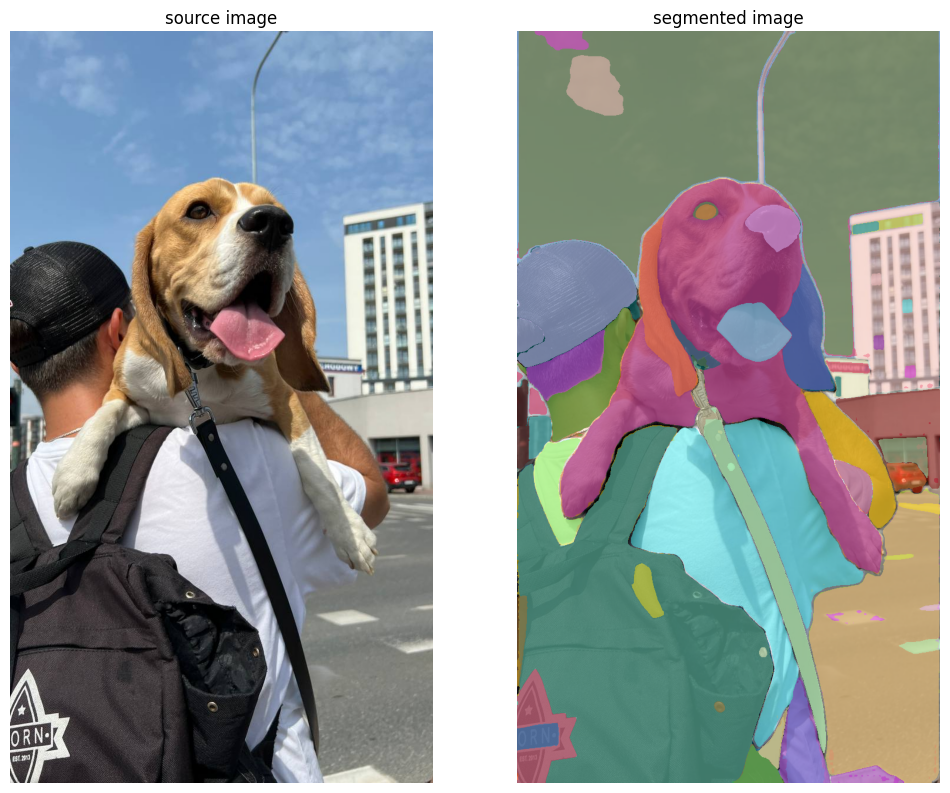

In [ ]:
mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### Interaction with segmentation results

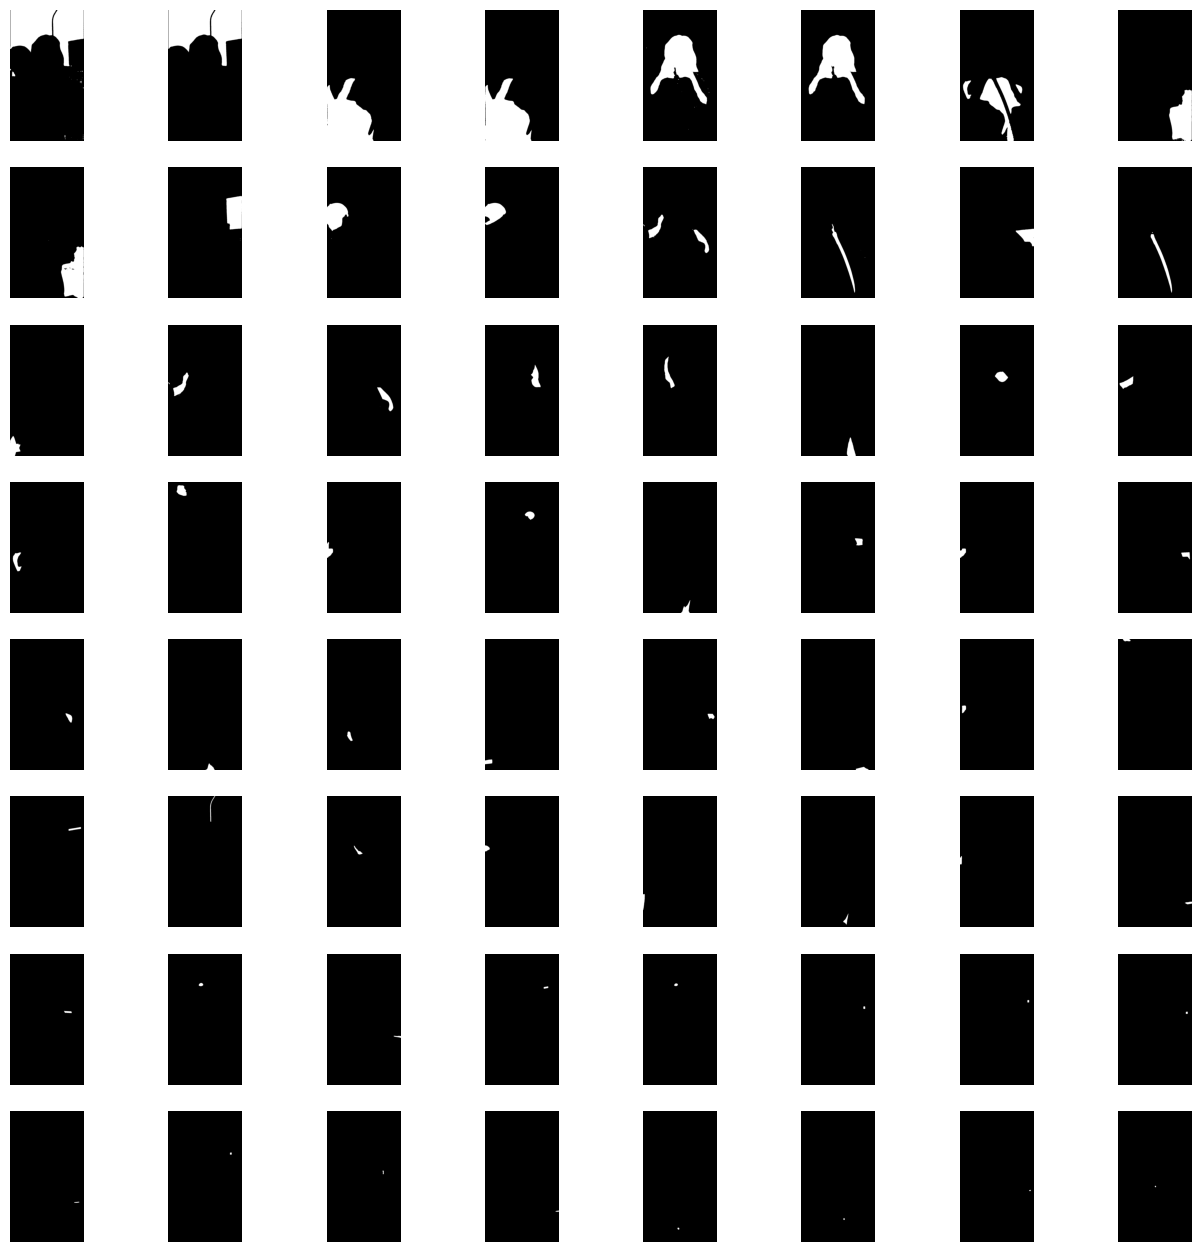

In [ ]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(8, int(len(masks) / 8)),
    size=(16, 16)
)

## Generate Segmentation with Bounding Box

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [ ]:
mask_predictor = SamPredictor(sam)

In [ ]:
import os

IMAGE_NAME = "/content/rot.jpg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

### Draw Box



In [ ]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** Execute cell below and use your mouse to draw bounding box on the image 👇

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
widget.bboxes

[{'x': 457, 'y': 499, 'width': 47, 'height': 88, 'label': ''}]

### Generate masks with SAM

**NOTE:** `SamPredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format. Let's reorganise your data first

In [ ]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [ ]:
import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

### Results visualisation with Supervision

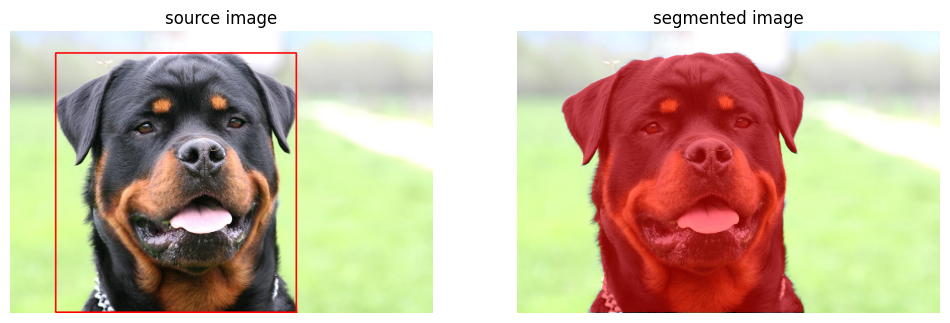

In [ ]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### Interaction with segmentation results

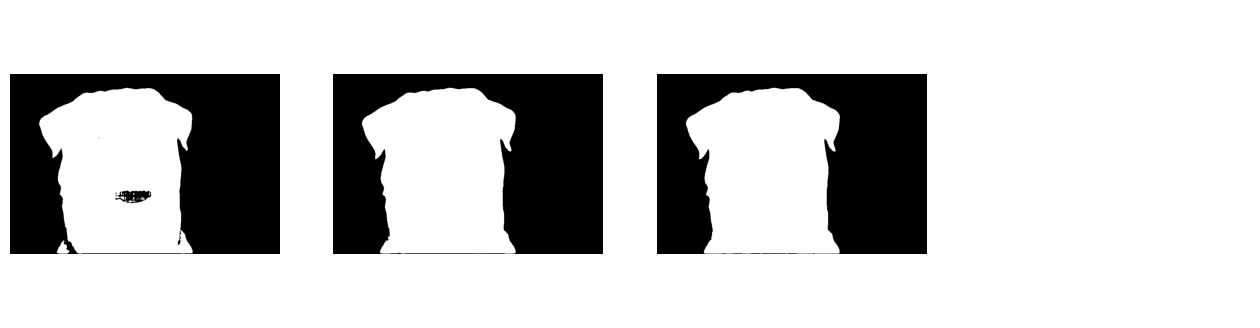

In [ ]:
import supervision as v

sv.plot_images_grid(
    images=masks,
    grid_size=(1, 4),
    size=(16, 4)
)

## Segment Anything in Roboflow Universe Dataset

### Utils Supporting Dataset Processing

A couple of helper functions that, unfortunately, we have to write ourselves to facilitate the processing of COCO annotations.

In [ ]:
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Union, Optional
from dataclasses_json import dataclass_json
from supervision import Detections


@dataclass_json
@dataclass
class COCOCategory:
    id: int
    name: str
    supercategory: str


@dataclass_json
@dataclass
class COCOImage:
    id: int
    width: int
    height: int
    file_name: str
    license: int
    date_captured: str
    coco_url: Optional[str] = None
    flickr_url: Optional[str] = None


@dataclass_json
@dataclass
class COCOAnnotation:
    id: int
    image_id: int
    category_id: int
    segmentation: List[List[float]]
    area: float
    bbox: Tuple[float, float, float, float]
    iscrowd: int


@dataclass_json
@dataclass
class COCOLicense:
    id: int
    name: str
    url: str


@dataclass_json
@dataclass
class COCOJson:
    images: List[COCOImage]
    annotations: List[COCOAnnotation]
    categories: List[COCOCategory]
    licenses: List[COCOLicense]


def load_coco_json(json_file: str) -> COCOJson:
    import json

    with open(json_file, "r") as f:
        json_data = json.load(f)

    return COCOJson.from_dict(json_data)


class COCOJsonUtility:
    @staticmethod
    def get_annotations_by_image_id(coco_data: COCOJson, image_id: int) -> List[COCOAnnotation]:
        return [annotation for annotation in coco_data.annotations if annotation.image_id == image_id]

    @staticmethod
    def get_annotations_by_image_path(coco_data: COCOJson, image_path: str) -> Optional[List[COCOAnnotation]]:
        image = COCOJsonUtility.get_image_by_path(coco_data, image_path)
        if image:
            return COCOJsonUtility.get_annotations_by_image_id(coco_data, image.id)
        else:
            return None

    @staticmethod
    def get_image_by_path(coco_data: COCOJson, image_path: str) -> Optional[COCOImage]:
        for image in coco_data.images:
            if image.file_name == image_path:
                return image
        return None

    @staticmethod
    def annotations2detections(annotations: List[COCOAnnotation]) -> Detections:
        class_id, xyxy = [], []

        for annotation in annotations:
            x_min, y_min, width, height = annotation.bbox
            class_id.append(annotation.category_id)
            xyxy.append([
                x_min,
                y_min,
                x_min + width,
                y_min + height
            ])

        return Detections(
            xyxy=np.array(xyxy, dtype=int),
            class_id=np.array(class_id, dtype=int)
        )

### Download Dataset from Roboflow

In [ ]:
%cd {HOME}

import roboflow
from roboflow import Roboflow


rf = Roboflow(api_key="0tupF6MkmIgM5t08RjhV")
project = rf.workspace("realtimeprojects").project("doc-wzoyb")
dataset = project.version(4).download("coco-segmentation")



/content
loading Roboflow workspace...
loading Roboflow project...
Exporting format coco-segmentation in progress : 85.0%
Version export complete for coco-segmentation format


Extracting Dataset Version Zip to doc-4 in coco-segmentation:: 100%|██████████| 913/913 [00:00<00:00, 2800.50it/s]


In [ ]:
import os

DATA_SET_SUBDIRECTORY = "test"
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"
IMAGES_DIRECTORY_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY)
ANNOTATIONS_FILE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, ANNOTATIONS_FILE_NAME)

In [ ]:
coco_data = load_coco_json(json_file=ANNOTATIONS_FILE_PATH)

CLASSES = [
    category.name
    for category
    in coco_data.categories
    if category.supercategory != 'none'
]

IMAGES = [
    image.file_name
    for image
    in coco_data.images
]

In [ ]:
CLASSES

['BookPage', 'document']

### Single Image Bounding Box to Mask

In [ ]:
# set random seed to allow easy reproduction of the experiment

import random
random.seed(10)

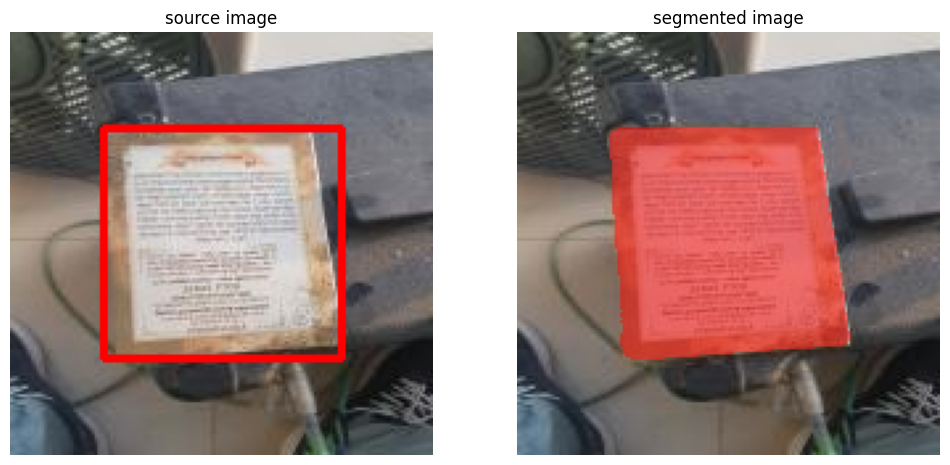

In [ ]:
EXAMPLE_IMAGE_NAME = random.choice(IMAGES)
EXAMPLE_IMAGE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, EXAMPLE_IMAGE_NAME)

# load dataset annotations
annotations = COCOJsonUtility.get_annotations_by_image_path(coco_data=coco_data, image_path=EXAMPLE_IMAGE_NAME)
ground_truth = COCOJsonUtility.annotations2detections(annotations=annotations)

# small hack - coco numerate classes from 1, model from 0 + we drop first redundant class from coco json
ground_truth.class_id = ground_truth.class_id - 1

# load image
image_bgr = cv2.imread(EXAMPLE_IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# initiate annotator
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

# annotate ground truth
annotated_frame_ground_truth = box_annotator.annotate(scene=image_bgr.copy(), detections=ground_truth, skip_label=True)

# run SAM inference
mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=ground_truth.xyxy[0],
    multimask_output=True
)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[annotated_frame_ground_truth, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)